In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.metrics import get_scorer_names
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

C:\Users\asiko\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
#Downcasting int64 to reduce memory

def reduce_int_memory(df, columns_to_reduce=[]):
    """
    You have to specify data frame and columns as a list
    
    """

    downcast_int_dict = {'int8': [-128, 127], 'int16': [-32768, 32767]}


    for column in df.loc[:, columns_to_reduce].columns:
        max_val = df[column].max()
        min_val = df[column].min()


        for key in downcast_int_dict.keys():
            if min_val > downcast_int_dict[key][0] and max_val < downcast_int_dict[key][1]:
                df[column] = df[column].astype(key)
                break
        
    
    return df

In [4]:
#change data types

def reduce_memory(df):
    
    memory_before_change = round(df.memory_usage(deep=True).sum()/1000000, 2)
    #Date
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
    

    #Only for Sales_df
    if 'Dept' in df.columns:
        df = reduce_int_memory(df, columns_to_reduce=['Store', 'Dept'])
        df.set_index('Date', inplace=True)
    
    #Floats
    columns_with_float = df.select_dtypes(include=[np.float64]).columns

    for column in columns_with_float:
        df[column] = df[column].astype('float32')

#     df['Weekly_Sales'] = df['Weekly_Sales'].astype('float32')

    memory_after_change = round(df.memory_usage(deep=True).sum()/1000000, 2)
    print(f"Memory reduced from {memory_before_change} MB to {memory_after_change} MB")
    #memory usage reduced from 13.3 MB to 6.0
    
    return df

In [5]:
def create_features_from_date(df):
    """
    date has to be in index
    """
    
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['dayofmonth'] = df.index.day
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['week'] = df.index.isocalendar().week
    
    return df
    

In [6]:
def merge_features(df):
    """
    Function used to merge features_df
    """

    df = df.reset_index().merge(features_df.iloc[:,:-1],
                           how='left',
                           on=['Date', 'Store'])\
                           .set_index('Date')
#                            .fillna(0)
    
    return df

In [7]:
def add_lag_features(df):
    
#     df['Sales_next_week'] = df.groupby(["Dept", "Store"])['Weekly_Sales'].shift(-1)
    df['lag_sales_1'] = df.groupby(["Dept", "Store"])['Weekly_Sales'].shift(1)
    df['lag_sales_4'] = df.groupby(["Dept", "Store"])['Weekly_Sales'].shift(4)
    # df['rolling_4'] = df.groupby(["Dept", "Store"])['Weekly_Sales'].rolling(4).mean().reset_index(level=0, drop=True).reset_index(level=0, drop=True)
    
    return df


In [8]:
def save_model(model, name):
    
    import pickle

    with open(name, 'wb') as f:
        pickle.dump(model, f)


In [9]:
def load_model(name_model):
    import pickle
    with open(name_model, 'rb') as f:
        model = pickle.load(f)
    return model

In [10]:
def get_r2(model, X_train, X_test, y_test, y_train):
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    print('R^2 test set: %.2f' % r2_score(y_test, y_pred_test))
    print('R^2 training set: %.2f' % r2_score(y_train, y_pred_train))

In [11]:
def print_feature_importance_xgb(model):
    
    #Feature importance
    sorted_idx = model.feature_importances_.argsort()
    plt.barh(X_test.columns[sorted_idx], model.feature_importances_[sorted_idx])
    plt.title("Feature Importance")
    print(plt.show())

In [12]:
def transform_mrkd_df(df):
    # make sure that data is sorted
    df = df.reset_index().sort_values(by=['Store', 'Dept', 'Date']).set_index("Date")
    
    #add time features
    df = create_features_from_date(df)

    
    #add lag features
    df = add_lag_features(df)
    
    #add features from csv file
    df = df.query('IsHoliday==True')\
            .reset_index()\
            .groupby(['Date', 'Store']).sum()\
            .reset_index()\
            .drop(["Dept", "IsHoliday"], axis=1)\
            .set_index("Date")
    
    df = merge_features(df)
    
    filter_col = [col for col in df if col.startswith('Mark')]
    
    #filter days with missing values
    df['Markdown_total'] = df[filter_col].sum(axis=1)
    df = df.query('Markdown_total>0')
    
    
    return df

# Load data

In [30]:
file_names = ["Features data set", 'sales data-set', 'stores data-set']
features_df = pd.read_csv (f".//Data//{file_names[0]}.csv")
sales_df = pd.read_csv (f".//Data//{file_names[1]}.csv")

# Transform & short EDA

In [31]:
features_df = reduce_memory(features_df)
sales_df = reduce_memory(sales_df)
mrkd_df = transform_mrkd_df(sales_df)

Memory reduced from 1.21 MB to 0.43 MB
Memory reduced from 38.78 MB to 6.32 MB


In [32]:
markd_train, markd_test = train_test_split(mrkd_df, test_size=0.2 )

<AxesSubplot: xlabel='Weekly_Sales', ylabel='Markdown_total'>

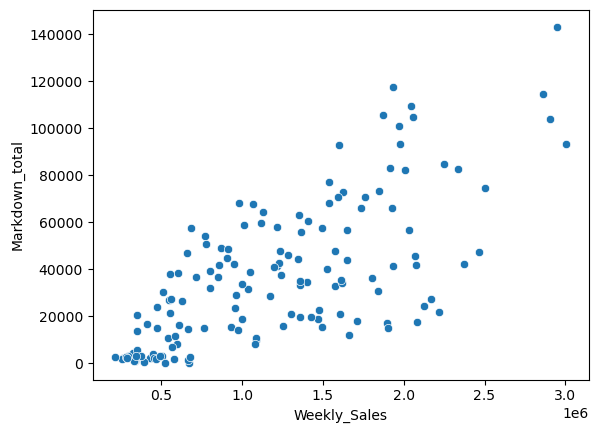

In [33]:
sns.scatterplot(data = markd_train, x='Weekly_Sales', y='Markdown_total')

<AxesSubplot: >

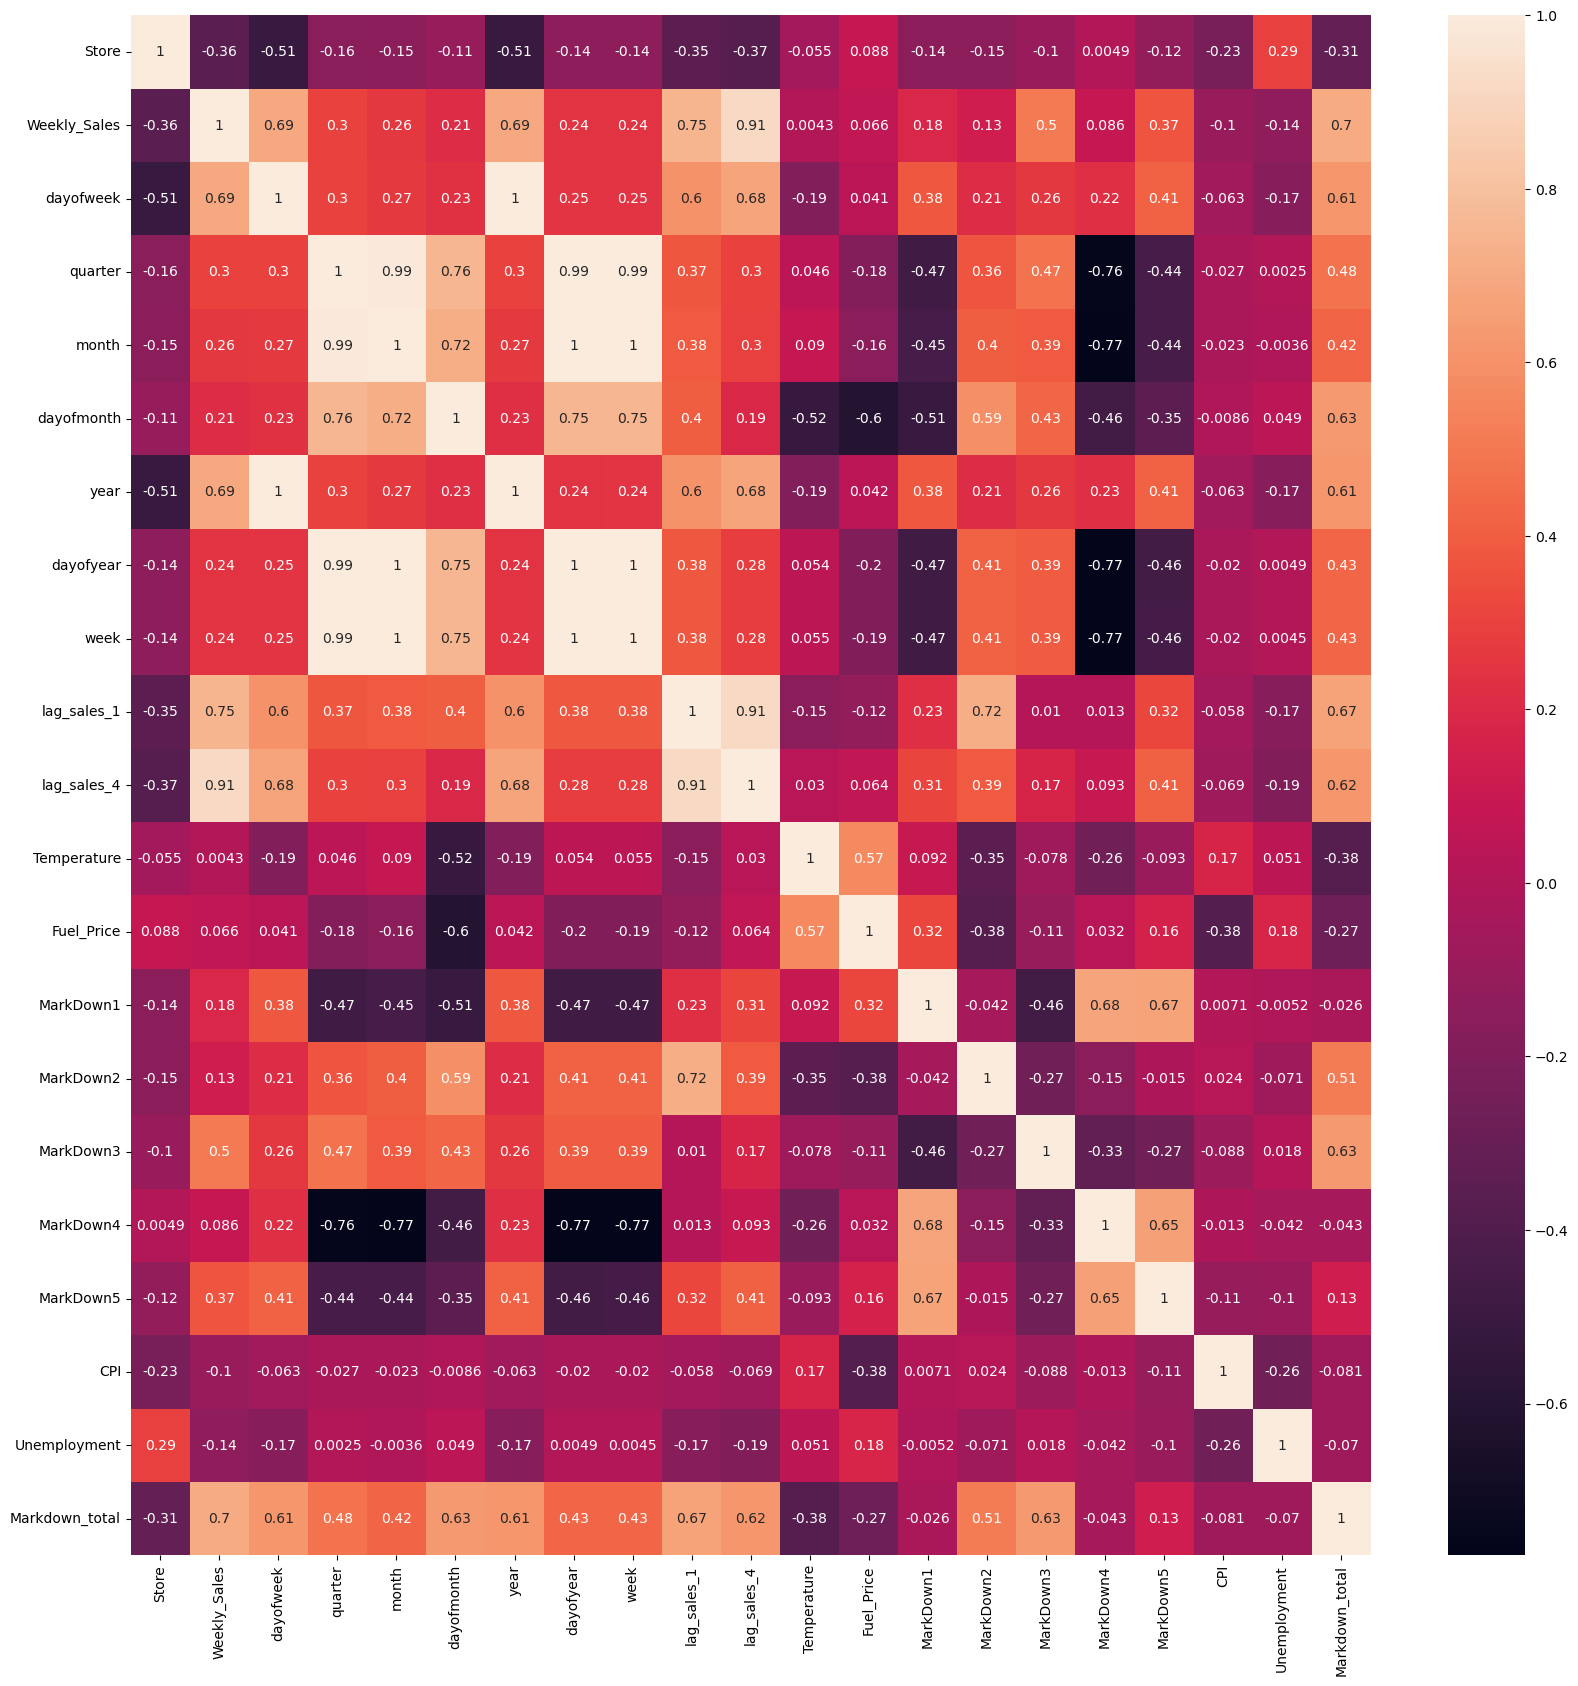

In [34]:
plt.figure(figsize=(20,20))
sns.heatmap(markd_train.corr(), annot=True)

In [19]:
#Conclusion: Sales is highly correleted with total Markdown

# Built models

In [35]:
#split x, y
y_train = markd_train.loc[:,"Weekly_Sales"].ravel()
X_train = markd_train.loc[:,markd_train.columns !='Weekly_Sales']
y_test = markd_test.loc[:,"Weekly_Sales"].ravel()
X_test = markd_test.loc[:,markd_test.columns !='Weekly_Sales']

In [23]:

def train_model(algo, X_train, y_train, X_test, y_test, param_grid=None, grid_type='Randomized'):
    steps = [('inputer', SimpleImputer()),
             ('scaler', MinMaxScaler()),
             ('model', algo)]
    clf = Pipeline(steps=steps)
    
    if param_grid is None:
        model = clf.fit(X_train, y_train)
    
    else:
        if grid_type == 'Randomized':
            
            clf = RandomizedSearchCV(estimator=clf, 
                               param_distributions=param_grid, 
                               scoring='neg_mean_squared_error',
                               cv=5,
                               n_jobs = -1,
                               return_train_score=True
                              )
        else:
            
            clf = GridSearchCV(estimator=clf, 
                               param_grid=param_grid, 
                               scoring='neg_mean_squared_error',
                               cv=5,
                               n_jobs = -1,
                               return_train_score=True
                              )

        if algo=='xgb':
            clf.fit(X_train, y_train, xgb__early_stopping_rounds=10)
        else:
            clf.fit(X_train, y_train)
        
        
        model = clf.best_estimator_

    score = model.score(X_test, y_test)
    return model, score

In [24]:
def test_algo(X_train, y_train, X_test, y_test, grid_type):
    

    algos = {
        "linearregression": {"algo": LinearRegression(), "params": None}, 
    #     "lasso": {"algo": Lasso(), "params": {"model__alpha": [0.001,0.01, 0.1,  0.7, 1],
    #                                          "model__fit_intercept":[True, False]}},
        "ridge": {"algo": Ridge(), "params": {"model__alpha": [0.001,0.01,  0.1,  0.7, 1],
                                              "model__solver":['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
                                              "model__fit_intercept":[True, False]}},
        "rf": {"algo": RandomForestRegressor(), "params":{"model__n_estimators":[10, 50, 100, 500, 1000],
                                                          "model__max_depth":[2, 5, 10, 20, 40, 60, 100],
                                                          "model__max_features":["auto", "sqrt", "log2"],
                                                          "model__min_samples_split":np.linspace(0.01, 1.0, 20) 
                                                         }},
        "xgb": {"algo": XGBRegressor(), "params":{"model__max_depth":[2, 3, 5, 7, 10],
                                                  "model__n_estimators":[100, 500, 1000],
                                                  "model__learning_rate":[0.001, 0.01, 0.1, 0.3],
                                                  "model__colsample_bytree":[0.5,1],
                                                  "model__subsample": [0.6, 1]

                                                         }}
    }



    
    result_dict = {}
    for key in algos.keys():
        print(key)
        result = train_model(algos[key]['algo'], 
                             X_train, y_train, X_test, y_test, 
                             algos[key]['params'],grid_type)
        print(result[1], result[0])
        result_dict[key] = {"score": result[1], "model": result[0]}
    
    return result_dict
    


In [44]:
def get_best_model(result_dict):
    
    max_value=0
    for k in result_dict.keys():
        if result_dict[k]['score'] > max_value:
            max_value = result_dict[k]['score']
            algorithm = k

    print(f"Score is: {max_value}")
    print(f" Type of algorithm is: {algorithm}")
    #wyciągniecie modelu
    best_model = result_dict[algorithm]['model']
    return best_model

In [46]:
def get_model(X_train, y_train, X_test, y_test, grid_type='Grid_search', loading_model='no', model_name = "main_model"):
    """
    load_model:
    - if = yes, then model will be loaded. In this case you have to specify model_name
    - if = no, model will be created and save
    
    grid_type:
    - you can specify 'Grid_search' or 'Randomized'
    """
    if loading_model == 'no':
        result_dict = test_algo(X_train, y_train, X_test, y_test, grid_type=grid_type)
        model = get_best_model(result_dict)
        get_r2(model, X_train, X_test, y_test, y_train)
        save_model(model = model, name = model_name)
    else:
        model = load_model(model_name)
    
    return model

In [47]:
model = get_model(X_train, y_train, X_test, y_test, grid_type='Grid_search',loading_model = 'no', model_name = 'mrkd_main_model')

linearregression
0.9586532834052136 Pipeline(steps=[('inputer', SimpleImputer()), ('scaler', MinMaxScaler()),
                ('model', LinearRegression())])
ridge
0.9595546132772687 Pipeline(steps=[('inputer', SimpleImputer()), ('scaler', MinMaxScaler()),
                ('model',
                 Ridge(alpha=0.01, fit_intercept=False, solver='lsqr'))])
rf


C:\Users\asiko\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


0.9682407407424649 Pipeline(steps=[('inputer', SimpleImputer()), ('scaler', MinMaxScaler()),
                ('model',
                 RandomForestRegressor(max_depth=20, max_features='auto',
                                       min_samples_split=0.01))])
xgb
0.9652630054490846 Pipeline(steps=[('inputer', SimpleImputer()), ('scaler', MinMaxScaler()),
                ('model',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, enable_categorical=False,
                              gamma=0, gpu_id=-1, importance_type=None,
                              interaction_constraints='', learning_rate=0.1,
                              max_delta_step=0, max_depth=2, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=1000, n_jobs=16, num_parallel_tree=1,
                          

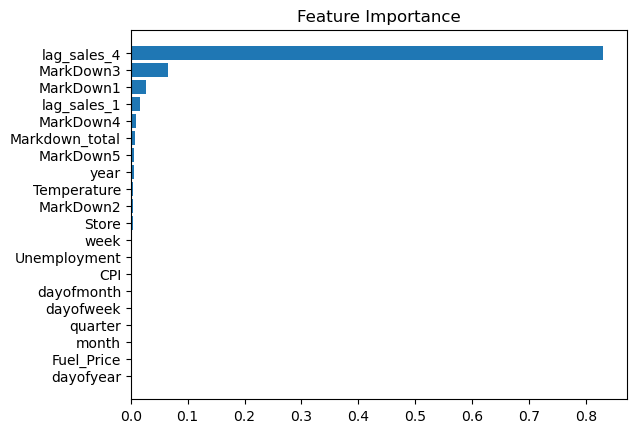

None


In [38]:
print_feature_importance_xgb(model[2])

In [ ]:
#Conclusion: Markdown is very important and has big influence on sales at holiday